AIX30009 Fall 2024

**_Copyright Notice_**

This notebook is available for educational purposes. You may not use or distribute this notebook for commercial purposes. You may make copies of this notebook and use or distribute it for educational purposes as long as you cite the author as the source of the notebook.

Jaeyoung Chun | School of Applied Artificial Intelligence | Handong Global University

# Fashion MNIST FIB (Fill in the Blank) Version

Replace ??? with proper values.

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1+cu121'

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
# set the random seed
torch.manual_seed(316)

# Load Data

In [5]:
# convert to tensor
# data augumentation -> 성능 개선을 위해 추가한 방법
# normalize the data

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=[0, 45]),
        transforms.RandomErasing(p=0.9, scale=(0.03, 0.03)),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

## Download

In [6]:
# download the dataset
dataset = datasets.CIFAR100('.', download=True, train=True, transform=transform)

100%|██████████| 169M/169M [00:04<00:00, 37.0MB/s]


Extracting ./cifar-100-python.tar.gz to .


## Split

In [7]:
# split
len_trainset = int(len(dataset) * 0.8)
len_valset = len(dataset) - len_trainset

trainset, valset = torch.utils.data.random_split(dataset, [len_trainset, len_valset])

In [8]:
len(trainset)

40000

In [9]:
len(valset)

10000

## Training Set

In [10]:
# loader for the training set
batch_size = 64
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

## Validation Set

In [11]:
# loader for the validatoin set
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True
)

# Explore Data

In [12]:
idx_to_class = { v:k for k, v in trainset.dataset.class_to_idx.items() }
idx_to_class

{0: 'apple',
 1: 'aquarium_fish',
 2: 'baby',
 3: 'bear',
 4: 'beaver',
 5: 'bed',
 6: 'bee',
 7: 'beetle',
 8: 'bicycle',
 9: 'bottle',
 10: 'bowl',
 11: 'boy',
 12: 'bridge',
 13: 'bus',
 14: 'butterfly',
 15: 'camel',
 16: 'can',
 17: 'castle',
 18: 'caterpillar',
 19: 'cattle',
 20: 'chair',
 21: 'chimpanzee',
 22: 'clock',
 23: 'cloud',
 24: 'cockroach',
 25: 'couch',
 26: 'crab',
 27: 'crocodile',
 28: 'cup',
 29: 'dinosaur',
 30: 'dolphin',
 31: 'elephant',
 32: 'flatfish',
 33: 'forest',
 34: 'fox',
 35: 'girl',
 36: 'hamster',
 37: 'house',
 38: 'kangaroo',
 39: 'keyboard',
 40: 'lamp',
 41: 'lawn_mower',
 42: 'leopard',
 43: 'lion',
 44: 'lizard',
 45: 'lobster',
 46: 'man',
 47: 'maple_tree',
 48: 'motorcycle',
 49: 'mountain',
 50: 'mouse',
 51: 'mushroom',
 52: 'oak_tree',
 53: 'orange',
 54: 'orchid',
 55: 'otter',
 56: 'palm_tree',
 57: 'pear',
 58: 'pickup_truck',
 59: 'pine_tree',
 60: 'plain',
 61: 'plate',
 62: 'poppy',
 63: 'porcupine',
 64: 'possum',
 65: 'rabbit',

In [13]:
# get a first batch
images, labels = next(iter(trainloader))

In [14]:
images.shape

torch.Size([64, 3, 32, 32])

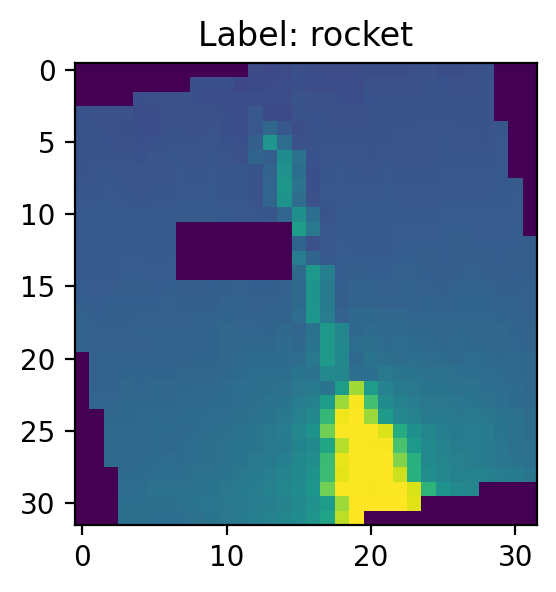

In [15]:
fig, ax = plt.subplots(figsize=(3,3))

img_idx = 0
label = idx_to_class[int(labels[0])] # color img

ax.imshow(images[0][0])
ax.set_title(f"Label: {label}")

plt.show()

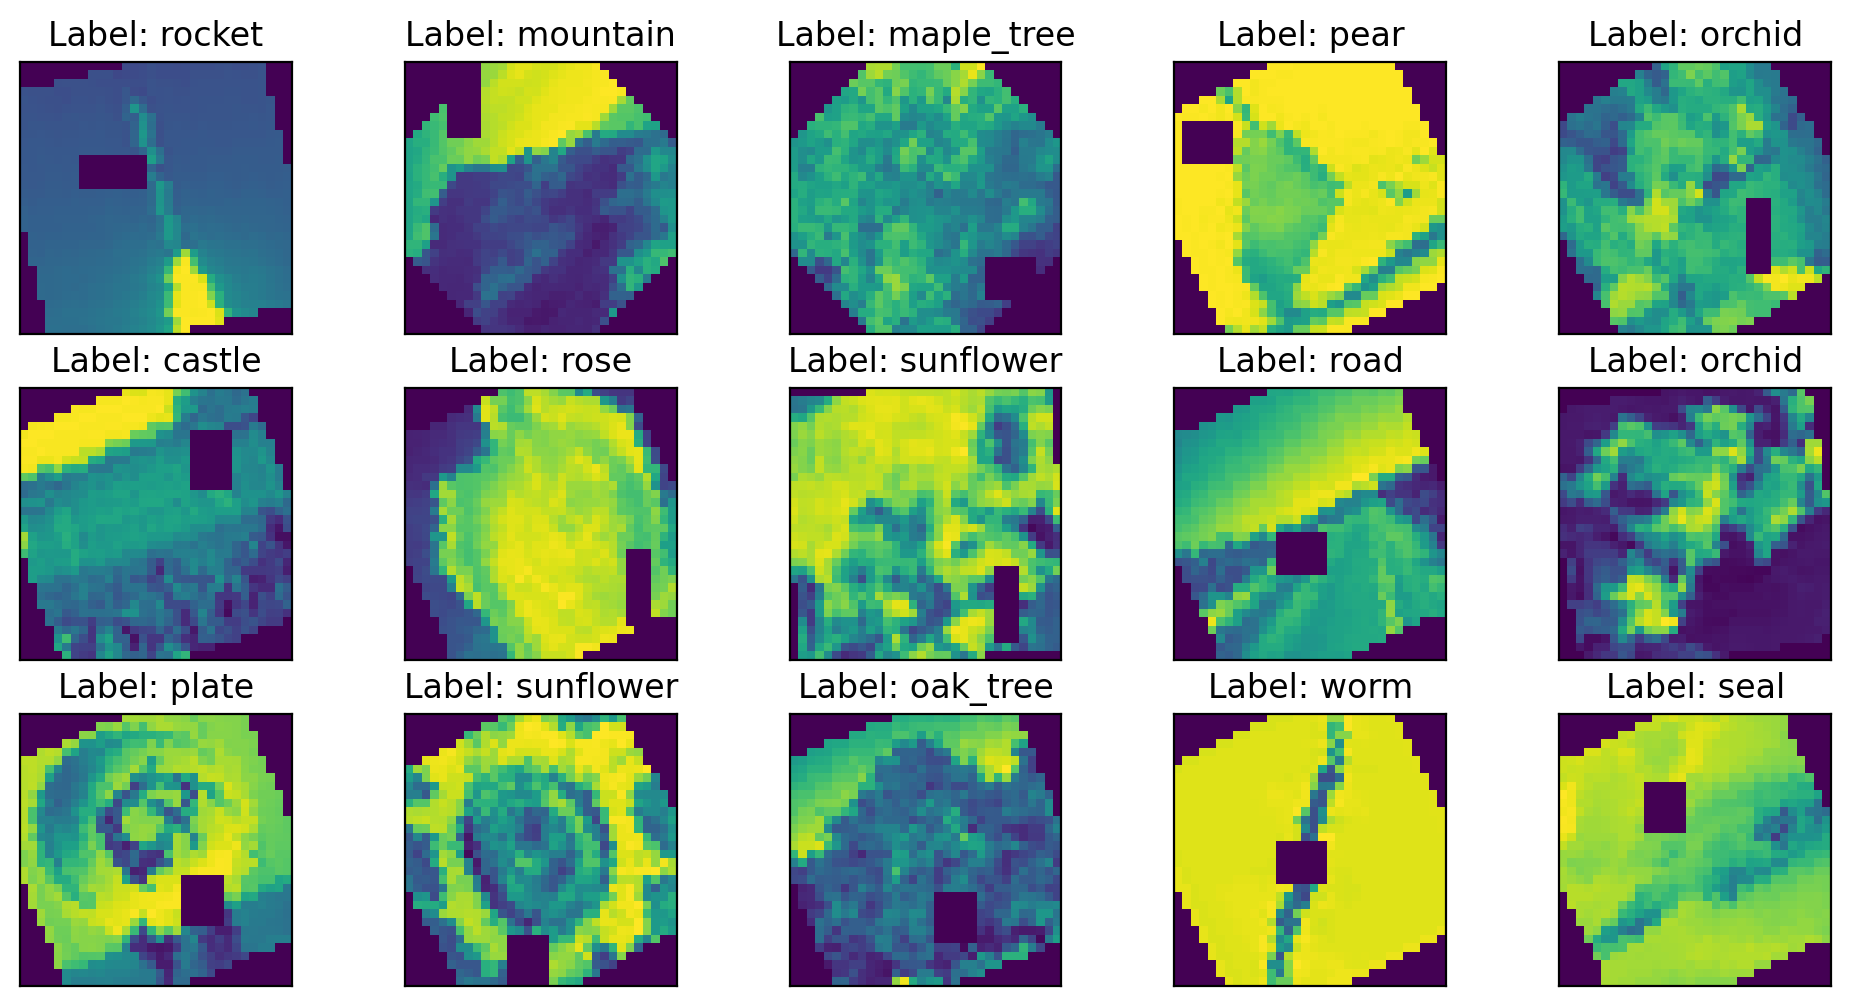

In [16]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(12,6))
ax = np.ravel(ax)

for index in range(15):
    ax[index].imshow(images[index][0]) # color img
    label = idx_to_class[int(labels[index])]
    ax[index].set_title(f"Label: {label}")
    ax[index].set_xticks([])
    ax[index].set_yticks([])

plt.show()

# Build Neural Network

In [17]:
from collections import OrderedDict
import torch.nn.functional as F

## 성능 개선을 위해 모델을 기존보다 더욱 복잡하게 설계

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extraction = nn.Sequential(
            OrderedDict([
                ("conv1", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)),
                ("bn1", nn.BatchNorm2d(64)),
                ("relu1", nn.ReLU()),
                ("pool1", nn.MaxPool2d(kernel_size=2, stride=2)),

                ("conv2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)),
                ("bn2", nn.BatchNorm2d(128)),
                ("relu2", nn.ReLU()),
                ("pool2", nn.MaxPool2d(kernel_size=2, stride=2)),

                ("conv3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)),
                ("bn3", nn.BatchNorm2d(256)),
                ("relu3", nn.ReLU()),
                ("pool3", nn.MaxPool2d(kernel_size=2, stride=2)),

                ("conv4", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)),
                ("bn4", nn.BatchNorm2d(512)),
                ("relu4", nn.ReLU()),
                ("pool4", nn.MaxPool2d(kernel_size=2, stride=2)),
            ])
        )

        self.classifier = nn.Sequential(
            OrderedDict([
                ("fc1", nn.Linear(512 * 2 * 2, 1024)),
                ("relu5", nn.ReLU()),
                ("dropout1", nn.Dropout(0.5)),

                ("fc2", nn.Linear(1024, 512)),
                ("relu6", nn.ReLU()),
                ("dropout2", nn.Dropout(0.5)),

                ("fc3", nn.Linear(512, 128)),
                ("relu7", nn.ReLU()),
                ("dropout3", nn.Dropout(0.5)),

                ("fc4", nn.Linear(128, 100))
            ])
        )

    def forward(self, x):
        out1 = self.feature_extraction(x)
        out2 = torch.flatten(out1, 1)
        out3 = self.classifier(out2)
        return out3

# 모델 인스턴스 생성 및 출력
model = Network()
print(model)


Network(
  (feature_extraction): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(512, eps=1e-0

In [18]:
total_params = 0
for name, param in model.named_parameters():
    print(name, param.shape, param.numel())
    total_params += param.numel()

print(f"Total number of parameters = {total_params}")

feature_extraction.conv1.weight torch.Size([64, 3, 3, 3]) 1728
feature_extraction.conv1.bias torch.Size([64]) 64
feature_extraction.bn1.weight torch.Size([64]) 64
feature_extraction.bn1.bias torch.Size([64]) 64
feature_extraction.conv2.weight torch.Size([128, 64, 3, 3]) 73728
feature_extraction.conv2.bias torch.Size([128]) 128
feature_extraction.bn2.weight torch.Size([128]) 128
feature_extraction.bn2.bias torch.Size([128]) 128
feature_extraction.conv3.weight torch.Size([256, 128, 3, 3]) 294912
feature_extraction.conv3.bias torch.Size([256]) 256
feature_extraction.bn3.weight torch.Size([256]) 256
feature_extraction.bn3.bias torch.Size([256]) 256
feature_extraction.conv4.weight torch.Size([512, 256, 3, 3]) 1179648
feature_extraction.conv4.bias torch.Size([512]) 512
feature_extraction.bn4.weight torch.Size([512]) 512
feature_extraction.bn4.bias torch.Size([512]) 512
classifier.fc1.weight torch.Size([1024, 2048]) 2097152
classifier.fc1.bias torch.Size([1024]) 1024
classifier.fc2.weight tor

In [19]:
# from torchinfo import summary

# summary(model, input_size=(batch_size, 3, 32, 32), device="cpu")

# Training and Validation

In [20]:
torch.cuda.is_available()

True

In [21]:
torch.cuda.device_count()

1

In [22]:
if torch.cuda.is_available():
    print(torch.cuda.current_device())

0


In [23]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA A100-SXM4-40GB


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
model.to(device)

Network(
  (feature_extraction): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(512, eps=1e-0

In [26]:
import time

In [27]:
from torch import optim

# 성능 개선을 위해 L2 norm + optimizer: Adam + lr_scheduler 설정.

weight_decay = 0.001  # L2 정규화 적용
learning_rate = 0.001

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.999), eps=1e-08)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# define the loss
criterion = nn.CrossEntropyLoss()

In [28]:
start_time = time.time()

n_epochs = 200

train_loss_history = []
val_loss_history = []
accuracy_history = []

for epoch in range(n_epochs):

    train_loss = 0

    model.train()

    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        # zero the gradients on each training pass
        optimizer.zero_grad()

        # make a forward pass through the network
        logits = model.forward(images)

        # use the network output to calculate the loss (output vs. ground truth)
        loss = criterion(logits, labels)

        # make a backward pass through the network to calculate the gradients (backpropagation)
        loss.backward()

        # update the weights
        optimizer.step()

        # keep track of the loss per epoch
        train_loss += loss.item()

    else:

        train_loss = train_loss / len(trainloader)
        train_loss_history.append(train_loss)

        val_loss = 0
        accuracy = 0

        with torch.no_grad():

            model.eval()

            for images, labels in valloader:

                images, labels = images.to(device), labels.to(device)

                logits = model.forward(images)

                loss = criterion(logits, labels)

                val_loss += loss.item()

                probabilities = logits.softmax(dim=1)

                top_probs, top_classes = probabilities.topk(k=1, dim=1)
                corrects = (top_classes == labels.view(*top_classes.shape))
                accuracy += torch.mean(corrects.type(torch.FloatTensor))

        val_loss = val_loss / len(valloader)
        val_loss_history.append(val_loss)

        accuracy = accuracy / len(valloader)
        accuracy_history.append(accuracy)

        metrics = f"Epoch: {epoch + 1:02}/{n_epochs:02}"
        metrics += " | "
        metrics += f"Train loss: {train_loss:.3f}"
        metrics += " | "
        metrics += f"Validation loss: {val_loss:.3f}"
        metrics += " | "
        metrics += f"Accuracy: {accuracy:.3f}"
        print(metrics)

        # 스케줄러 업데이트
        scheduler.step()  # 학습률 감소

print("Elapsed: {0:.2f} seconds".format(time.time() - start_time))

Epoch: 01/200 | Train loss: 4.479 | Validation loss: 4.225 | Accuracy: 0.043
Epoch: 02/200 | Train loss: 4.200 | Validation loss: 4.073 | Accuracy: 0.055
Epoch: 03/200 | Train loss: 4.081 | Validation loss: 3.915 | Accuracy: 0.071
Epoch: 04/200 | Train loss: 3.975 | Validation loss: 3.802 | Accuracy: 0.085
Epoch: 05/200 | Train loss: 3.857 | Validation loss: 3.679 | Accuracy: 0.107
Epoch: 06/200 | Train loss: 3.741 | Validation loss: 3.572 | Accuracy: 0.126
Epoch: 07/200 | Train loss: 3.631 | Validation loss: 3.494 | Accuracy: 0.146
Epoch: 08/200 | Train loss: 3.538 | Validation loss: 3.435 | Accuracy: 0.158
Epoch: 09/200 | Train loss: 3.452 | Validation loss: 3.256 | Accuracy: 0.186
Epoch: 10/200 | Train loss: 3.361 | Validation loss: 3.172 | Accuracy: 0.200
Epoch: 11/200 | Train loss: 3.301 | Validation loss: 3.154 | Accuracy: 0.207
Epoch: 12/200 | Train loss: 3.241 | Validation loss: 3.062 | Accuracy: 0.228
Epoch: 13/200 | Train loss: 3.198 | Validation loss: 3.008 | Accuracy: 0.241

# Metrics

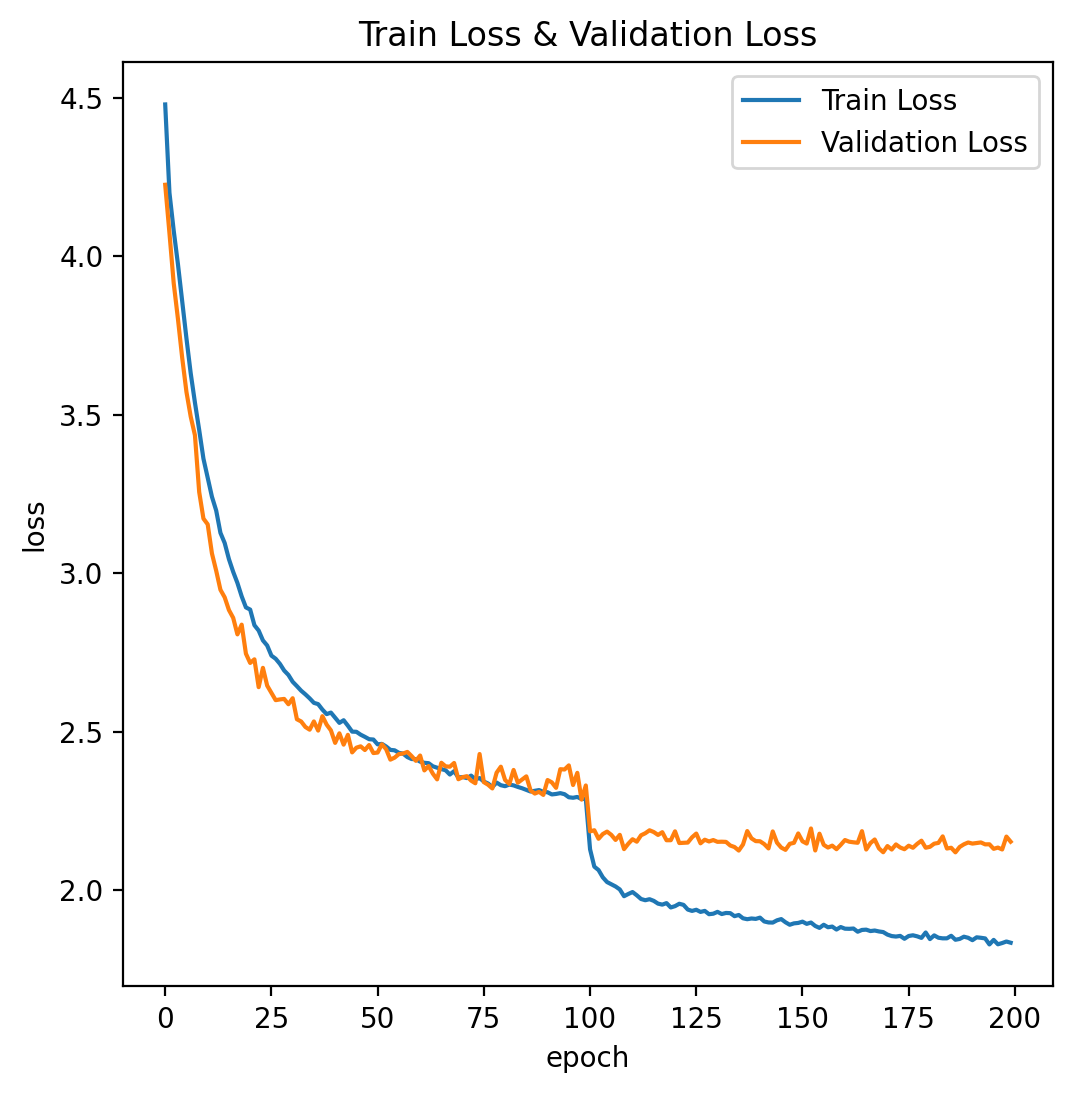

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")
ax.plot(val_loss_history, label="Validation Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss & Validation Loss")
ax.legend()

plt.show()

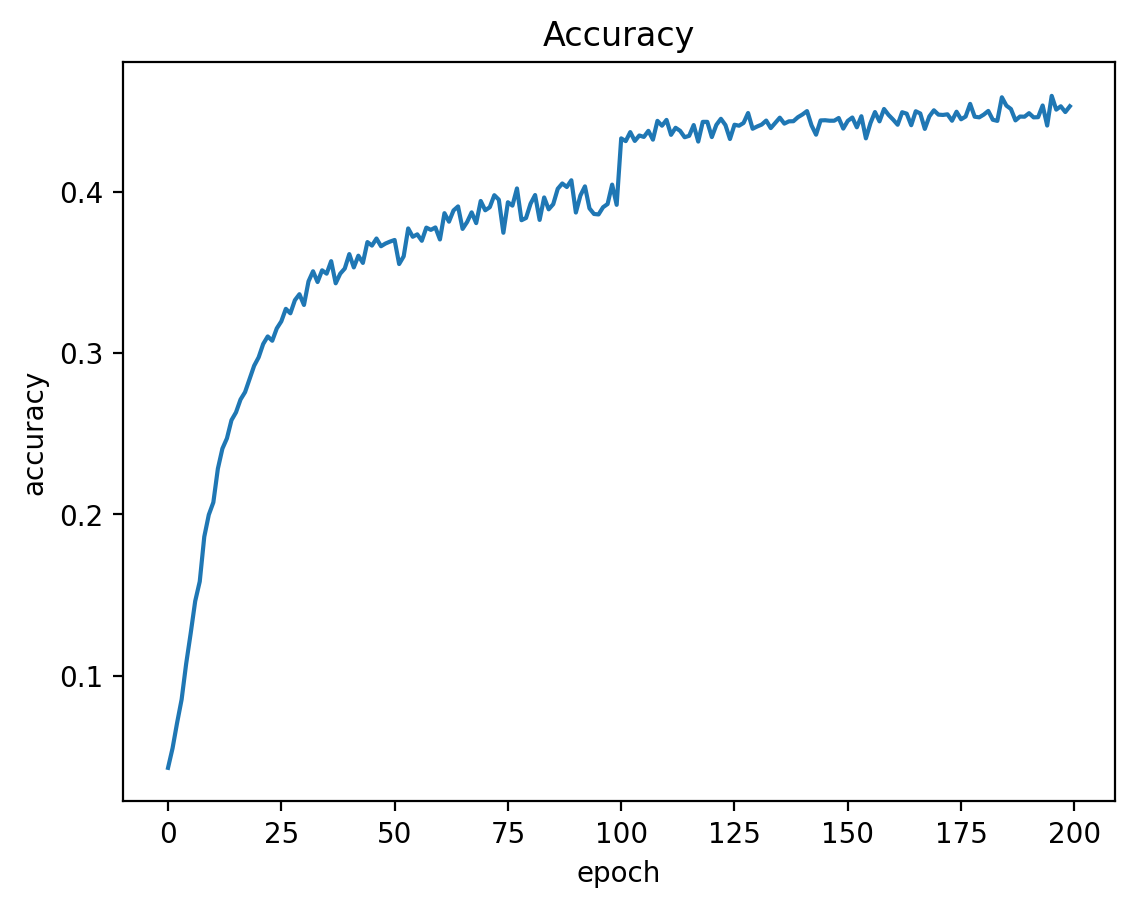

In [30]:
fig, ax = plt.subplots()

ax.plot(accuracy_history, label="Accuracy")

ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy")

plt.show()

In [31]:
# download the testset
testset = datasets.CIFAR100('.', download=True, train=False, transform=transform)

# loader for the testset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True
)

Files already downloaded and verified


In [32]:
total = 0
total_corrects = 0
with torch.no_grad():

    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)

        logits = model.forward(images)

        probabilities = logits.softmax(dim=1)

        top_probs, top_classes = probabilities.topk(k=1, dim=1)
        corrects = (top_classes == labels.view(*top_classes.shape))
        corrects = int(torch.sum(corrects).cpu().numpy())
        total_corrects += corrects

        total += labels.size(0)


In [33]:
total_corrects / total * 100.0

45.92

### 성능 개선

성능을 개선하기 위해 (Accuracy가 최소 50% 이상) 나오게 하기 위하여 여러 방법을 적용하였다.

1. Data Augumentation
2. CNN 모델을 더욱 복잡하고 설계
3. 옵티마이저 설정(L2 norm + optimizer: Adam + lr_scheduler)
4. 100 epochs를 수행 결과를 보면 overfitting이 발견되지 않았다.

결과적으로 더 많은 epochs를 수행하면 결국 50% 이상의 accuracy score를 얻을 수 있을 것이다.